In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt
from einops import rearrange, repeat

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11, 12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v4'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_3') # cvt_nuscenes_multiclass Sparse
device = torch.device('cpu') # cuda:5
model_version = '2024_0910_213526'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, dataset = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='val', batch_size=1)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4


/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Dataset length: 6019


In [3]:
batch = dataset.__getitem__(4004)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v[None]
    # elif isinstance(v, list):
    #     if isinstance(v[0], torch.Tensor):
    #         batch[k] = [i.to(device) for i in v]
    else:
        batch[k] = v

In [4]:
import sys
metric_depth = True
if metric_depth:
    sys.path.append("../../../Depth-Anything-V2/metric_depth")
else:
    sys.path.append("../../../Depth-Anything-V2")

In [97]:
from depth_anything_v2.dpt import DepthAnythingV2
if metric_depth:

    model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
    }

    encoder = 'vitl' # or 'vits', 'vitb'
    dataset = 'vkitti' # 'hypersim' for indoor model, 'vkitti' for outdoor model
    max_depth = 60 # 20 for indoor model, 80 for outdoor model

    model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
    ckpt_path = f'/media/hcis-s20/SRL/Depth-Anything-V2/ckpt/depth_anything_v2_metric_{dataset}_{encoder}.pth'
    # ckpt_path = '/media/hcis-s20/SRL/Depth-Anything-V2/metric_depth/exp/nuscenes/latest.pth'
    pth = torch.load(ckpt_path, map_location='cpu')
    if 'model' in pth:
        new_pth = {}
        pth = pth['model']
        for k in pth:
            new_pth[k.replace('module.','')] = pth[k]
        pth = new_pth
    model.load_state_dict(pth)
    model = model.to(device).eval()
else:
    model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }

    encoder = 'vitl' # or 'vits', 'vitb', 'vitg'

    model = DepthAnythingV2(**model_configs[encoder])
    model.load_state_dict(torch.load(f'/media/hcis-s20/SRL/Depth-Anything-V2/ckpt/depth_anything_v2_{encoder}.pth', map_location='cpu'))
    model = model.to(device).eval()


In [98]:
from depth_anything_v2.util.transform import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose

input_size = 518
transform = Compose([
    Resize(
        width=input_size,
        height=input_size,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

def image2tensor(raw_image, DEVICE=torch.device('cpu')):        
                
    images = []
    for image in raw_image:
        # image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0
        
        image = transform({'image': image})['image']
        image = torch.from_numpy(image)
        
        image = image.to(DEVICE)
        images.append(image)
    
    return torch.stack(images)

In [99]:
images = [img.permute(1,2,0).numpy() for img in batch['image'][0]]
h, w = images[0].shape[:2]
images = image2tensor(images, device)
with torch.no_grad():
    depths = model(images)
    depths = F.interpolate(depths[:, None], (h, w), mode="bilinear", align_corners=True)[:, 0]


Text(0.5, 1.0, 'Image')

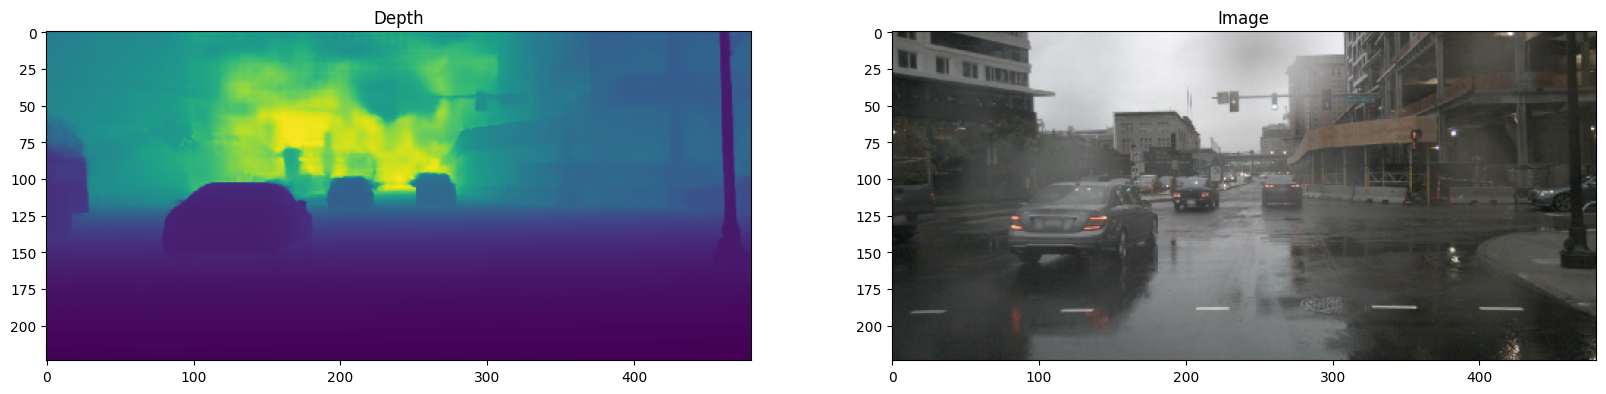

In [100]:
i = 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))
ax1.imshow(depths[i])
ax1.set_title('Depth')
ax2.imshow(batch['image'][0,i].permute(1,2,0).numpy())
ax2.set_title('Image')

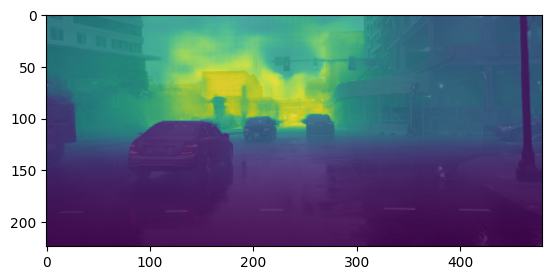

In [101]:
plt.imshow(depths[i])
plt.imshow(batch['image'][0,i].permute(1,2,0).numpy(), alpha=0.2)

In [23]:
mask = (batch['depth'][0] != 0.0).cpu().numpy().reshape(-1)
depth_metric = batch['depth'][0].cpu().numpy().reshape(-1)[mask]
depths_reshape = depths.reshape(-1)[mask]

In [24]:
if metric_depth:
    # Prepare the A matrix and b vector
    A = np.vstack([depths_reshape, np.ones(depths_reshape.shape)]).T
    b = depth_metric

    # Solve the least squares problem
    scale, shift= np.linalg.lstsq(A, b)[0]

    # Extract shift and scale
    # shift, scale = solution

    print(f"Shift: {shift}, Scale: {scale}")
    depths_rescale = (shift + (scale * depths))
else:
    # Prepare the A matrix and b vector
    A = np.vstack([depths_reshape, np.ones(depths_reshape.shape)]).T
    b = 1.0 / depth_metric

    # Solve the least squares problem
    scale, shift= np.linalg.lstsq(A, b)[0]

    # Extract shift and scale
    # shift, scale = solution

    print(f"Shift: {shift}, Scale: {scale}")
    depths_rescale = 1. / (shift + (scale * depths))

print("Mean error origin:", np.mean(np.abs(depth_metric - depths_reshape)))
print("Mean error after re-scale:", np.mean(np.abs(depth_metric - depths_rescale.reshape(-1)[mask])))

Shift: -0.35992745855158204, Scale: 1.5163376039641587


/tmp/ipykernel_609861/1482668226.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  scale, shift= np.linalg.lstsq(A, b)[0]


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

In [102]:
def get_pixel_depth(depth, img_feats, lidar2img):
    eps = 1e-6

    B, N, H, W = img_feats.shape
    depth = F.interpolate(depth, size=[H,W])
    depth = depth.permute(0,1,3,2).unsqueeze(-1)

    coords_h = torch.arange(H, device=img_feats[0].device).float()
    coords_w = torch.arange(W, device=img_feats[0].device).float() 
    coords = torch.stack(torch.meshgrid([coords_w, coords_h])).permute(1, 2, 0)[None,None] # W, H, 2
    coords = coords.expand(B, N, W, H, 2)

    coords = torch.cat((coords, depth), dim=-1)
    coords = torch.cat((coords, torch.ones_like(coords[..., :1])), dim=-1)
    coords[..., :2] = coords[..., :2] * torch.maximum(coords[..., 2:3], torch.ones_like(coords[..., 2:3])*eps)
    
    img2lidars = lidar2img.inverse() # b n 4 4
    coords = coords.unsqueeze(-1)
    # coords = coords.view(1, 1, W, H, 4, 1).repeat(B, N, 1, 1, 1, 1)
    img2lidars = img2lidars.view(B, N, 1, 1, 4, 4).repeat(1, 1, W, H, 1, 1)
    coords3d = torch.matmul(img2lidars, coords).squeeze(-1)[..., :3] # B N W H 3
    return coords3d.permute(0,1,4,3,2)

depths_tensor = depths.unsqueeze(0)
# depths_tensor = batch['depth'][:,:,0] * 0.75
coord_3d = get_pixel_depth(depths_tensor, depths_tensor, batch['lidar2img'][0].unsqueeze(0)).squeeze(0)

tensor(23.0749)


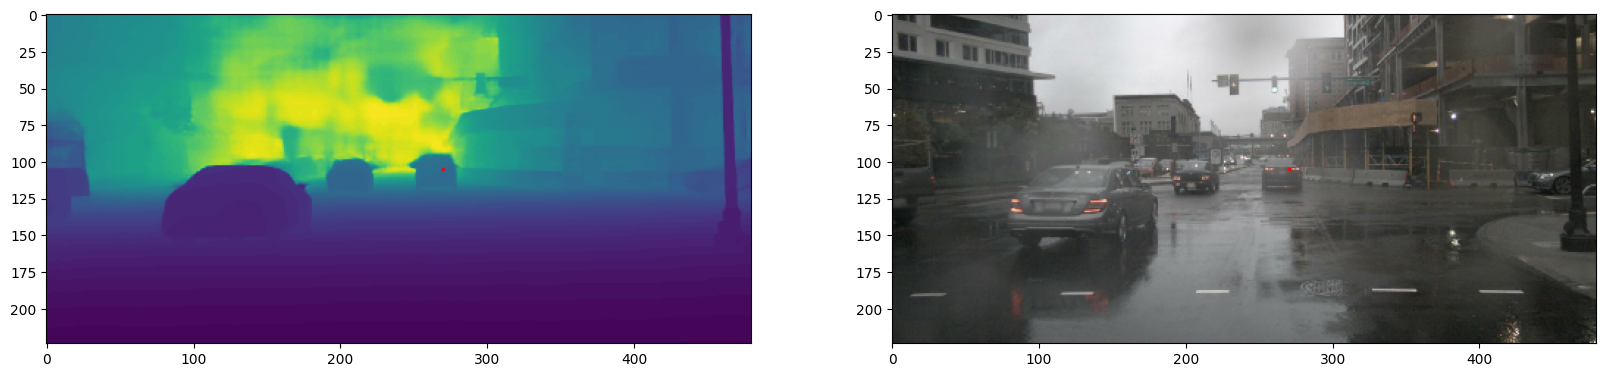

In [110]:
x = 270 # 450
y = 105 # 500 
pts = coord_3d[i,:,y,x]
pts[-1] = 1
projected_point = batch['view'][0] @ pts
# plt.imshow(depths[i])
# plt.scatter([x],[y],c='r',s=2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))
ax1.imshow(batch['depth'][0,i,0].cpu().numpy())
ax1.scatter([x],[y],c='r',s=2)
ax2.imshow(batch['image'][0,i].permute(1,2,0).numpy())
ax2.scatter([x],[y],c='r',s=2)
print(depths[i][y,x])

tensor([102.1890,  50.6948])


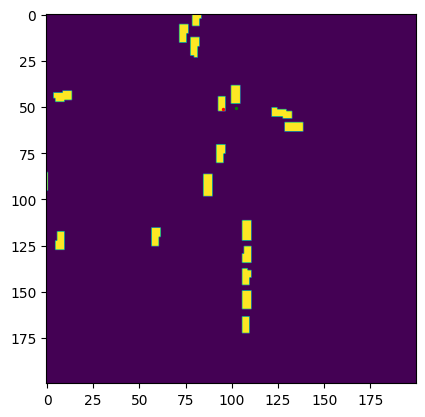

In [111]:
x = 95
y = 51 # 119
plt.imshow(batch['bev'][0,4])
plt.scatter([x],[y],c='r',s=2)
plt.scatter([projected_point[0]],[projected_point[1]],c='g',s=2)
print(projected_point[:2])

In [ ]:
from PIL import Image
image = Image.open("/media/hcis-s20/SRL/nuscenes/trainval/depths/CAM_FRONT/n015-2018-08-02-17-16-37+0800__CAM_FRONT__1533201470412460.jpg")

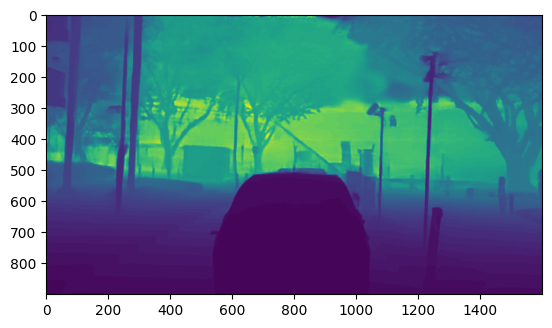

In [ ]:
import numpy as np
image = np.asarray(image)
plt.imshow(image)

In [ ]:
image[400,1000]

56

In [2]:
import threading
def print_numbers(i, j):
    print(i, j)

# Create multiple threads
threads = []
for j in range(6):
    threads.append(threading.Thread(target=print_numbers, args=(j,j+2)))

for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

print("Both threads have finished execution")

0 2
1 3
2 4
3 5
4 6
5 7
Both threads have finished execution
